# Bayes analysis of SIR model with changing points

## Libraries

In [1]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_func

from utils import *
from mcmc import *
from clustering import *


## Simulations

### Ground Truth

In [2]:
# setting the ground truths and the scenarios
gt_changing_points = [1, 26, 51, 76]


gt_total_time = 100


gt_delta = np.zeros(gt_total_time)
gt_delta[np.array(gt_changing_points)-1]=1
gt_eta = np.cumsum(gt_delta)
gt_K = np.sum(gt_delta)


gt_betas = [0.10, 0.4, 0.2, 0.05]
gt_gammas = [0.01, 0.08, 0.15, 0.25]


gt_total_population = 1_000_000
gt_init_infected = 50

#bool to save or not the simulations
save_npz = True


gt_changing_points_tmp = gt_changing_points.copy()
gt_changing_points_tmp.append(gt_total_time + 1)

#Compute the number of days for which a parameter hold its value
gt_days = np.array(gt_changing_points_tmp[1:]) - np.array(gt_changing_points_tmp[:-1]) 


#Generate arrays where each element of hte first vector 
#is repeated a number of time equal to the element of the second.
gt_beta_time = np.repeat(gt_betas, gt_days) 
gt_gamma_time = np.repeat(gt_gammas, gt_days) 

### Vector Initializazion

In [3]:
# setting the lvectors for the simulations
S = np.zeros(gt_total_time + 1)
I = np.zeros(gt_total_time + 1)
R = np.zeros(gt_total_time + 1)
P = np.zeros(gt_total_time + 1)
N = np.zeros(gt_total_time + 1)

N[0] = gt_total_population
S[0] = N[0] - gt_init_infected
I[0] = gt_init_infected
R[0] = 0
P[0] = I[0] / N[0]

### Simulation

In [4]:
# generate the simulation
for t in range(1, gt_total_time + 1):
    D_I = np.random.binomial(S[t - 1], 1 - np.exp(-gt_beta_time[t - 1] * P[t - 1]))
    D_R = np.random.binomial(I[t - 1], gt_gamma_time[t - 1])

    S[t] = S[t - 1] - D_I
    I[t] = I[t - 1] + D_I - D_R
    R[t] = R[t - 1] + D_R
    N[t] = S[t] + I[t] + R[t]
    P[t] = I[t] / N[t]

In [5]:
# save the simulation
if save_npz:
    np.savez(
        "gt_data.npz",
        S=S,
        I=I,
        R=R,
    )

In [6]:
# load the simulation data
simulation = np.load('gt_data.npz')

### Population Plot

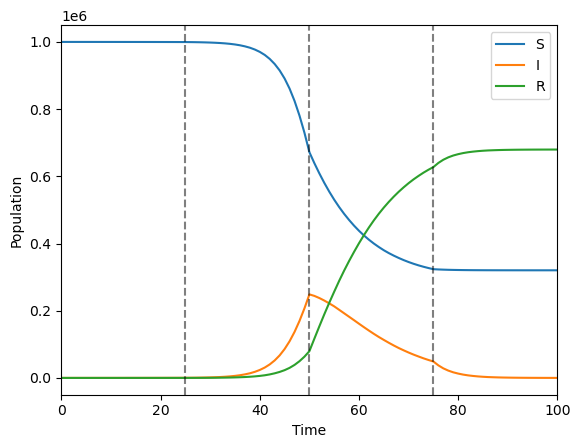

In [7]:
# plot the data
plot_population_data(S, R, I, gt_changing_points)

## MCMC algorithm

### Data preparation

In [8]:
# reshape and prepare the data
S = simulation["S"]
R = simulation["R"]
I = simulation["I"]

T = gt_total_time

In [9]:
#Save initial conditions
S_0 = S[0]
I_0 = I[0]
R_0 = R[0]
N_0 = S_0 + I_0 + R_0
P_0 = I_0 / N_0

In [10]:
S = S[1:]
R = R[1:]
I = I[1:]

P = I / N_0

In [11]:
delta_R = R[1:] - R[:-1]
delta_R = np.concatenate([[R[0] - R_0], delta_R])

delta_I = S[:-1] - S[1:]
delta_I = np.concatenate([[S_0 - S[0]], delta_I])

print("Modified length: ", R.shape)
print("T: ", T)

Modified length:  (100,)
T:  100


### MCMC hyper-parameter

In [12]:
N = 15_000  # n samplings
burnin = 5000
thinning = 10
p = 0.01

### Algorithm parameters

In [13]:
betas = np.zeros([N, T])
gammas = np.zeros([N, T])
bs = np.zeros([N, T])
rs = np.zeros([N, T])
deltas = np.zeros([N, T])

In [14]:
# init
delta_0 = np.random.binomial(1, p, size=T) 
delta_0[0] = 1
K_0 = np.sum(delta_0) # Number of Changeing points
eta_0 = np.cumsum(delta_0) #Number of Changing points up to time t

# vectors of K elements
r_0 = np.random.gamma(shape=0.1, scale=10, size=K_0)
b_0 = np.random.gamma(shape=0.1, scale=10, size=K_0)

r_0 = r_0[eta_0-1]
b_0 = b_0[eta_0-1]

beta_0 = np.random.exponential(1/b_0)
gamma_0 = np.random.beta(r_0, 1)

In [15]:
delta = delta_0.copy()
beta = beta_0.copy()
gamma = gamma_0.copy()
r = r_0.copy()
b = b_0.copy()

### Simulation

In [16]:
from tqdm.notebook import tqdm

In [17]:
K = np.sum(delta)
eta = np.cumsum(delta)
for n in tqdm(range(N)):

    delta_ = propose_delta(delta, T)
    delta = accept_delta(delta, delta_, beta, gamma, T, p)

    b = update_b(delta, beta)
    r = update_r(delta, gamma)

    beta = update_beta(delta, T, S_0, P_0, S, P, delta_I)
    gamma = update_gamma(r, T, I_0, I, delta_R)

    betas[n, :] = beta
    gammas[n, :] = gamma
    deltas[n, :] = delta
    rs[n, :] = r
    bs[n, :] = b

  0%|          | 0/15000 [00:00<?, ?it/s]

## Analysis of data

In [18]:
beta_samples = betas[burnin::thinning, :]
delta_samples = deltas[burnin::thinning, :]
b_samples = bs[burnin::thinning, :]
r_samples = rs[burnin::thinning, :]

eta_samples = np.cumsum(delta_samples, axis=1)

n_samples = eta_samples.shape[0]
q = np.zeros((T, T))
for n in range(n_samples):
    q += (eta_samples[n, :] == (eta_samples[n, :])[:, None]).astype(int)
q = q / n_samples

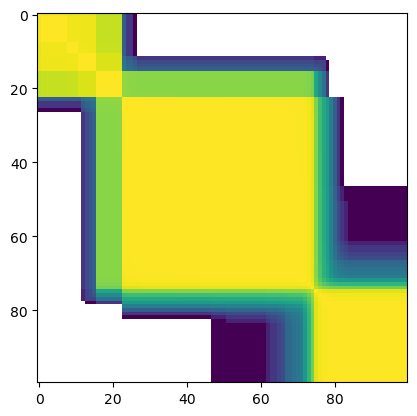

In [19]:
import matplotlib.colors as col
plt.imshow(q, norm = 'log')


### Clustering

In [20]:
delta_hat = np.array([0] * T)
delta_hat[0] = 1


eta_hat = np.cumsum(delta_hat)

continue_add = True
continue_swap = True

In [21]:
delta_final = clustering(delta_hat, eta_hat, q, T, continue_add, continue_swap)

### Changing points 

In [22]:
eta_final= np.cumsum(delta_final)
K_final= np.sum(delta_final)

tau_final= np.where(delta_final==1)[0]

In [23]:
tau_final

array([ 0, 23, 75])

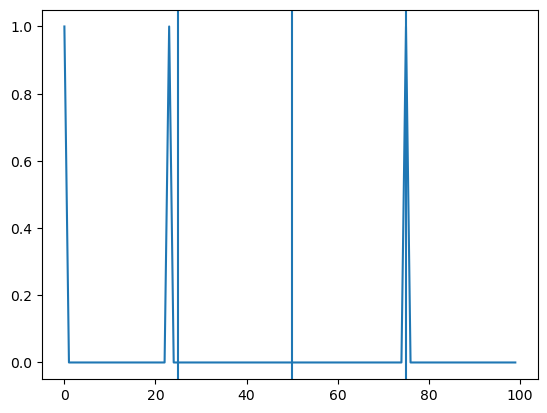

In [24]:
plt.plot(delta_final)
plt.axvline(25)
plt.axvline(75)
plt.axvline(50)

### Confidence intervals

In [25]:
alpha=0.05

In [26]:
def constraint_lhs(deltas, tau_l, tau_u):
    n_samples = deltas.shape[0]
    sum_tau = np.sum(deltas[:, tau_l:tau_u]) / n_samples
    return sum_tau

In [27]:
def possible_taus(tau_k, delta_tau):
    lower= tau_k
    upper= tau_k +delta_tau
    possible=[]
    for i in range(delta_tau+1):
        if upper<=T and lower>=0:
            possible.append((lower, upper))
            lower-=1
            upper-=1
    return possible

# possible_taus(4, 4)

In [28]:
ci_tau = []
for tau_k in tau_final:
    for delta_tau in range(2, T):
        candidate = []
        possible_taus_list = possible_taus(tau_k, delta_tau)
        for tau_l, tau_u in possible_taus_list:
            sum_tau = constraint_lhs(delta_samples, tau_l, tau_u)
            if sum_tau >= 1 - alpha:
                candidate.append([sum_tau, tau_l, tau_u])
        if len(candidate) > 0:
            break

    if len(candidate) == 0:
        ci_tau.append(np.array([0, T]))
    else:
        candidate = np.array(candidate)
        index_max_candidate = np.argmax(candidate[:, 0])
        ci_tau.append(candidate[index_max_candidate, 1:])

### Final Beta and Gamma

In [29]:
sum_beta = np.zeros(T)
sum_gamma = np.zeros(T)
n_smaples_reduced = delta_samples.shape[0]
for g in range(n_smaples_reduced):
    sum_beta += 1 / b_samples[g, :]
    sum_gamma+= r_samples[g, :]/(1+r_samples[g, :])
beta_final = sum_beta / n_smaples_reduced
gamma_final = sum_gamma / n_smaples_reduced

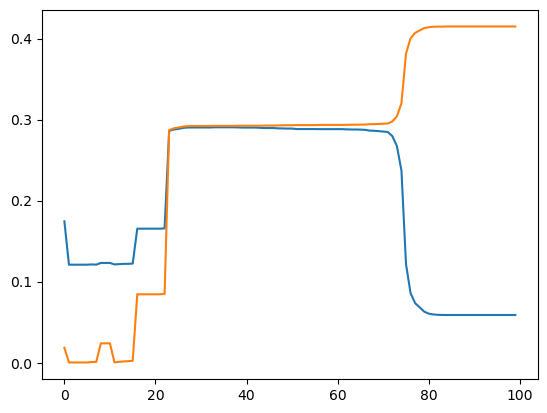

In [30]:
plt.plot(beta_final)
plt.plot(gamma_final)

## Bayesian analysis     

#### Plots

In [31]:
posterior_frequency = np.sum(delta_samples[:, 1:], axis = 0)/n_samples

Text(0.5, 0, 'Time[Days]')

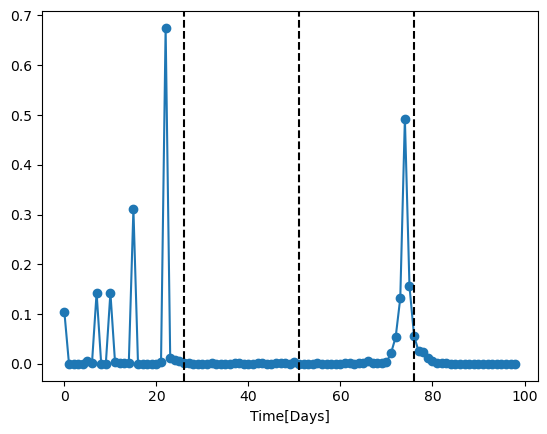

In [32]:
plt.plot(posterior_frequency, 'o-')
for gt in gt_changing_points[1:]:
    plt.axvline(gt, linestyle = '--', c = 'k')



plt.xlabel('Time[Days]')

#### Changing Points

In [33]:
K_final = np.sum(delta_final)

In [34]:
tau_final

array([ 0, 23, 75])

In [35]:
ci_tau

[array([0., 2.]), array([16., 24.]), array([72., 80.])]

### Metrics

#### ARI

In [36]:
TP = 0
FP = 0
FN = 0
TN = 0
for i in range(T):
    for j in range(i+1, T):
        TP = TP + int(eta_final[i]==eta_final[j] and gt_eta[i]==gt_eta[j])
        FP = FP + int(eta_final[i]!=eta_final[j] and gt_eta[i]==gt_eta[j])
        FN = FN + int(eta_final[i]==eta_final[j] and gt_eta[i]!=gt_eta[j])
        TN = TN + int(eta_final[i]!=eta_final[j] and gt_eta[i]!=gt_eta[j])

TP = TP*2/(T*(T-1))
FP = FP*2/(T*(T-1))
FN = FN*2/(T*(T-1))
TN = TN*2/(T*(T-1))

In [37]:
ARI = (TP + TN - ((TP+FP)*(TP+FN)+(TN+FP)*(TN+FN)))/(1-((TP+FP)*(TP+FN) + (TN+FP)*(TN+FN)))
print('ARI:', ARI)

ARI: 0.6443677229079016


#### Mutual information  (NON sono definiti k1 e k2)

In [38]:
MI = 0


for k1 in range(int(K_final)):
    for k2 in range(int(K_final)):
        n_k1 = np.sum(gt_eta == k1)
        n_k2 = np.sum(eta_final == k2)
        n_k1k2 = np.sum((gt_eta == k1) & (eta_final == k2))
        if n_k1k2 > 0:
            MI += n_k1k2/T * (np.log(T * n_k1k2) - np.log(n_k1 * n_k2))

In [39]:
print('MI:', MI)

MI: 0.444893276371209
